<a href="https://colab.research.google.com/github/eubielaraujo/MalariaDiagnosisCNN/blob/main/Malaria_Diagnosis_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [ ]:
dataset, dataset_info = tfds.load(
    "malaria", with_info=True, shuffle_files=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/incomplete.IE2U2V_1.0.0/malaria-train.tfrecord*...:   0%|         …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [ ]:
def split(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)

  train_ds = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))
  val_test_ds = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_ds = val_test_ds.take(int(VAL_RATIO*DATASET_SIZE))
  test_ds = val_test_ds.skip(int(TEST_RATIO*DATASET_SIZE))

  return train_ds, val_ds, test_ds

In [ ]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

train_ds, val_ds, test_ds = split(dataset['train'], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

In [ ]:
train_ds

<_TakeDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

In [ ]:
def get_label_str(label):
  if label == 0:
    return 'Parasitized'
  else:
    return 'Uninfected'

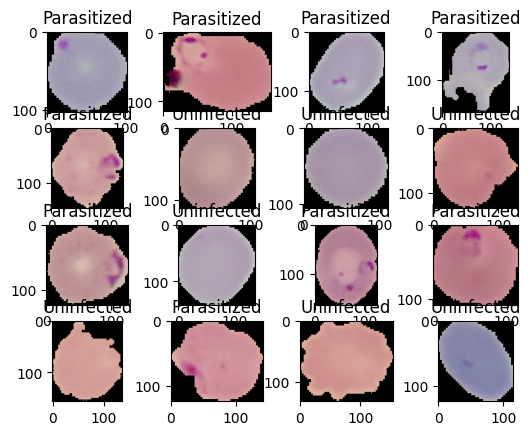

In [ ]:
for i, sample in enumerate(train_ds.take(16)):
  ax = plt.subplot(4,4,i+1)
  plt.imshow(sample['image'])
  plt.title(get_label_str(sample['label'].numpy()))

In [ ]:
IM_SIZE = 224

In [ ]:
def resize_rescale(inputs):
  return tf.image.resize(inputs['image'], (IM_SIZE, IM_SIZE))/255., inputs['label']

In [ ]:
train_dataset = train_ds.map(resize_rescale)

In [ ]:
for image, label in train_dataset.take(1):
  print(image, label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)


In [ ]:
np.unique(image)

array([0.0000000e+00, 2.4972958e-05, 2.5500556e-05, ..., 8.5091227e-01,
       8.5093659e-01, 8.5098040e-01], dtype=float32)